<a href="https://colab.research.google.com/github/Ajah-Stephen/MSCPROJECT/blob/main/MSCPROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [2]:
rolls = pd.read_csv('/content/RR.L.csv')

In [3]:
# Displaying the first few rows of the dataframe to understand its structure
print(rolls.head())

         Date       Open       High        Low      Close  Adj Close   Volume
0  1990-01-30  53.698799  53.698799  53.698799  53.698799  25.111080  6303136
1  1990-01-31  54.304798  54.304798  54.304798  54.304798  25.394464  4854872
2  1990-02-01  54.304798  54.304798  54.304798  54.304798  25.394464  5243504
3  1990-02-02  54.304798  54.304798  54.304798  54.304798  25.394464  3312486
4  1990-02-05  54.914101  54.914101  54.914101  54.914101  25.679398  9469885


In [4]:
rolls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8806 entries, 0 to 8805
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8806 non-null   object 
 1   Open       8806 non-null   float64
 2   High       8806 non-null   float64
 3   Low        8806 non-null   float64
 4   Close      8806 non-null   float64
 5   Adj Close  8806 non-null   float64
 6   Volume     8806 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 481.7+ KB


In [5]:
rolls.shape

(8806, 7)

**DATA CLEANING AND DATA PREPROCESSING**

In [6]:
# Converting the 'Date' column to datetime format
rolls['Date'] = pd.to_datetime(rolls['Date'])

In [7]:
# Checking for missing values
missing_values = rolls.isnull().sum()
missing_values

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
# Displaying data types and missing values
rolls.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

**APPLYING EXPLORATORY DATA ANALYSIS**

In [9]:
rolls.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,8806,8806.000000,8806.000000,8806.000000,8806.000000,8806.000000,8.806000e+03
mean,2007-02-08 18:47:49.861458176,148.503190,150.402119,146.577036,148.517906,125.670724,2.555938e+07
min,1990-01-30 00:00:00,23.163799,23.678600,22.048500,22.048500,13.052999,0.000000e+00
25%,1998-07-08 06:00:00,65.373497,66.179953,64.515602,65.240097,38.514699,1.083693e+07
50%,2006-12-24 12:00:00,100.471001,102.650101,98.146103,100.076401,89.790592,1.840933e+07
75%,2015-09-13 06:00:00,222.201401,225.071205,219.455994,222.544495,209.377423,3.203425e+07
max,2024-06-03 00:00:00,459.299988,468.100006,458.600006,460.899994,460.899994,2.934018e+09
std,NaN,103.853493,104.849897,102.813588,103.858884,106.373755,3.908861e+07


Statistic Breakdown:

[A] Count: This is the number of Non-Null values in each of the column
[B] Mean: This is the Average value for each of the column.
[C] Min: This is the minimum value observed in each column
[D] 25% : This is the Percentile (Lower Quartile) value
[E] 50% : This is the Median Percentile value
[F] 75% : This is the Percentile (Upper Quartile) value
[G] Max: This is the maximum value observed in each column
[H] Std: This is the Standard Deviation of each column that measures variability
1. The Mean (Average) closing price is approximately 148.52, while the Maximum closing price seen is 460.90.

2. The Volume traded ranges from 0 (Zero) minimum to 2.93 billion maximum shares.

3. The Adjusted Closing price a standard deviation of approximately 106.37

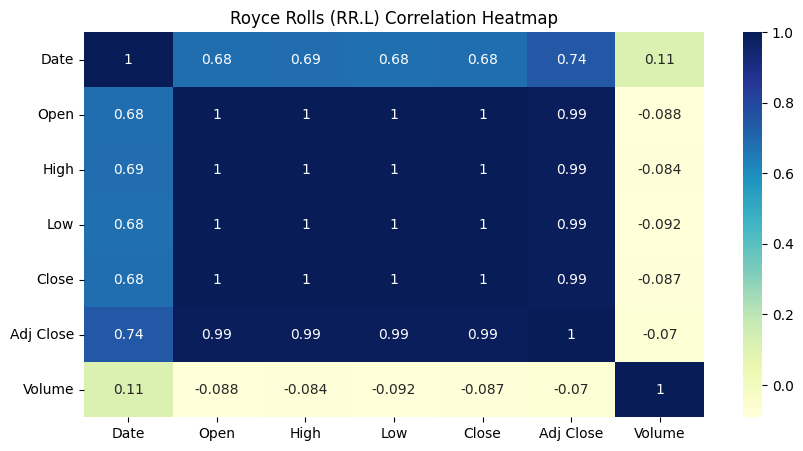

In [10]:
# Calculating the Correlation Matrix
correlation_matrix = rolls.corr()

# Creating heatmap
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.title('Royce Rolls (RR.L) Correlation Heatmap')
plt.show()

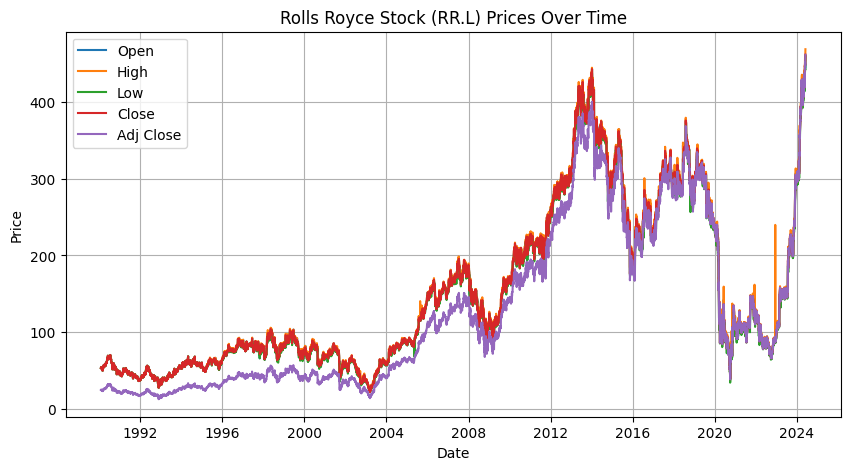

In [11]:
# Plotting time series of stock prices
plt.figure(figsize=(10, 5))

# Plot stock prices
plt.plot(rolls['Date'], rolls['Open'], label='Open')
plt.plot(rolls['Date'], rolls['High'], label='High')
plt.plot(rolls['Date'], rolls['Low'], label='Low')
plt.plot(rolls['Date'], rolls['Close'], label='Close')
plt.plot(rolls['Date'], rolls['Adj Close'], label='Adj Close')
plt.title('Rolls Royce Stock (RR.L) Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

**TIME SERIES**

Stock Prices:
The plots for Open, High, Low, Close, and Adj Close show significant variations over time. There are periods of sharp increases and decreases, indicating volatility.

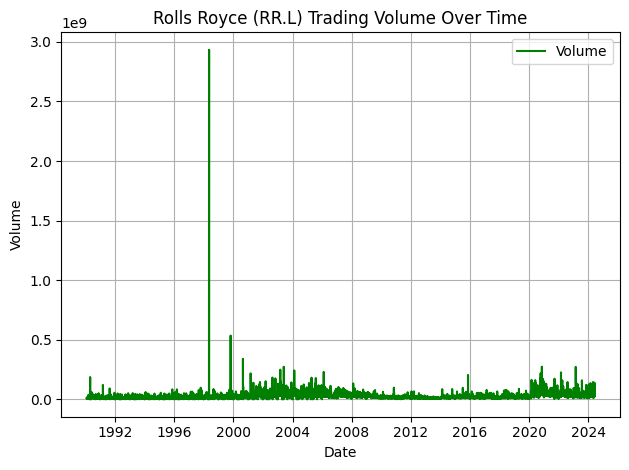

In [12]:
# Plotting time series of stock prices
fig = plt.plot(figsize=(10, 5))

# Ploting trading volume
plt.plot(rolls['Date'], rolls['Volume'], label='Volume', color='green')
plt.title('Rolls Royce (RR.L) Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)

plt.tight_layout()

TIME SERIES:

Trading Volume: The trading volume also shows variability, with some periods showing higher trading activity than others.

In [13]:
rolls.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-01-30,53.698799,53.698799,53.698799,53.698799,25.111080,6303136
1,1990-01-31,54.304798,54.304798,54.304798,54.304798,25.394464,4854872
2,1990-02-01,54.304798,54.304798,54.304798,54.304798,25.394464,5243504
3,1990-02-02,54.304798,54.304798,54.304798,54.304798,25.394464,3312486
4,1990-02-05,54.914101,54.914101,54.914101,54.914101,25.679398,9469885


**GETTING THE OUTLIERS**

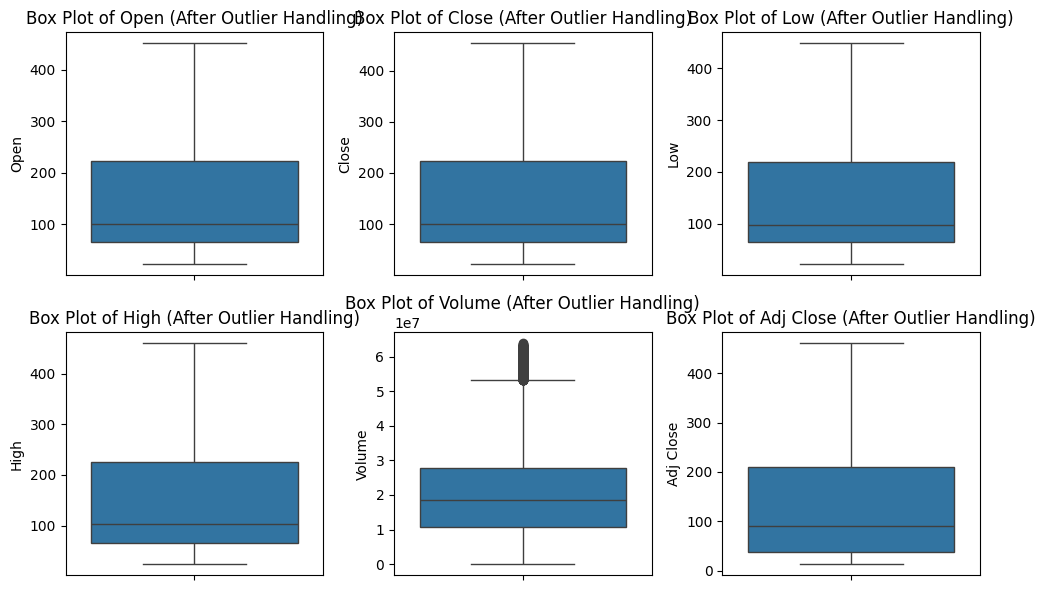

In [14]:
# Selecting Columns for Outlier Analysis
columns_outliers = ['Open', 'Close', 'Low', 'High', 'Volume', 'Adj Close']

# Detect and Replace Outliers using IQR Method
for column in columns_outliers:
    Q1 = rolls[column].quantile(0.25)
    Q3 = rolls[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Getting the Outliers using median statistics
    rolls[column] = np.where((rolls[column] < lower_bound) | (rolls[column] > upper_bound),
                          rolls[column].median(), rolls[column])

# Creating Box Plots After Outlier Handling
plt.figure(figsize=(10, 6))
for i, column in enumerate(columns_outliers, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=rolls, y=column)
    plt.title(f'Box Plot of {column} (After Outlier Handling)')

plt.tight_layout()
plt.show()

In [15]:
# Defining the function to detect and handle outliers
def detect_and_handle_outliers(data, column):
    Q1 = np.percentile(data[column], 25)
    Q3 = np.percentile(data[column], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)][column]

    # Handling outliers by replacing them with the median
    data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound),
                            data[column].median(), data[column])

    return outliers

# Columns to check for outliers
columns_outliers = ['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume']

# Detecting and handling outliers for each column and printing results
for column in columns_outliers:
    outliers = detect_and_handle_outliers(rolls, column)
    print(f'Outliers in {column}:')
    print(outliers)
    print(f'Number of outliers in {column}: {len(outliers)}')
    print('\n')

Outliers in Open:
Series([], Name: Open, dtype: float64)
Number of outliers in Open: 0


Outliers in Close:
Series([], Name: Close, dtype: float64)
Number of outliers in Close: 0


Outliers in High:
Series([], Name: High, dtype: float64)
Number of outliers in High: 0


Outliers in Low:
Series([], Name: Low, dtype: float64)
Number of outliers in Low: 0


Outliers in Adj Close:
Series([], Name: Adj Close, dtype: float64)
Number of outliers in Adj Close: 0


Outliers in Volume:
79      53874204.0
80      61440397.0
90      56767696.0
288     62351255.0
491     54891329.0
           ...    
8742    60796416.0
8754    63149087.0
8757    60052616.0
8783    54038891.0
8798    63080461.0
Name: Volume, Length: 318, dtype: float64
Number of outliers in Volume: 318




**APPLYING FEATURE ENGINEERING**

In [16]:
# Calculating the Short-Term (10 Days) Moving Avearge, and Long-Term (50 Days) Moving Average
rolls['MA10'] = rolls['Adj Close'].rolling(window=10).mean()
rolls['MA50'] = rolls['Adj Close'].rolling(window=50).mean()

In [17]:
rolls.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA50
0,1990-01-30,53.698799,53.698799,53.698799,53.698799,25.111080,6303136.0,NaN,NaN
1,1990-01-31,54.304798,54.304798,54.304798,54.304798,25.394464,4854872.0,NaN,NaN
2,1990-02-01,54.304798,54.304798,54.304798,54.304798,25.394464,5243504.0,NaN,NaN
3,1990-02-02,54.304798,54.304798,54.304798,54.304798,25.394464,3312486.0,NaN,NaN
4,1990-02-05,54.914101,54.914101,54.914101,54.914101,25.679398,9469885.0,NaN,NaN


In [18]:
# Calculating the Daily Returns
rolls['Daily Return'] = rolls['Adj Close'].pct_change()

In [19]:
rolls.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA50,Daily Return
0,1990-01-30,53.698799,53.698799,53.698799,53.698799,25.111080,6303136.0,NaN,NaN,NaN
1,1990-01-31,54.304798,54.304798,54.304798,54.304798,25.394464,4854872.0,NaN,NaN,0.011285
2,1990-02-01,54.304798,54.304798,54.304798,54.304798,25.394464,5243504.0,NaN,NaN,0.000000
3,1990-02-02,54.304798,54.304798,54.304798,54.304798,25.394464,3312486.0,NaN,NaN,0.000000
4,1990-02-05,54.914101,54.914101,54.914101,54.914101,25.679398,9469885.0,NaN,NaN,0.011220


The line of code below on VOLATILITY, computes the rolling standard deviation (volatility) of the Daily Return column over a window of 10 periods and assigns the result to the Volatility column in the DataFrame.

In financial analysis, volatility measures how much an asset's price fluctuates over time. By calculating the rolling standard deviation, we can identify periods of increased or decreased volatility in the time series data1. The square root of the number of trading days (252 in a year) is multiplied to annualize the result2.

In [20]:
rolls['Volatility'] = rolls['Daily Return'].rolling(window=10).std()

In [21]:
rolls.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA50,Daily Return,Volatility
0,1990-01-30,53.698799,53.698799,53.698799,53.698799,25.111080,6303136.0,NaN,NaN,NaN,NaN
1,1990-01-31,54.304798,54.304798,54.304798,54.304798,25.394464,4854872.0,NaN,NaN,0.011285,NaN
2,1990-02-01,54.304798,54.304798,54.304798,54.304798,25.394464,5243504.0,NaN,NaN,0.000000,NaN
3,1990-02-02,54.304798,54.304798,54.304798,54.304798,25.394464,3312486.0,NaN,NaN,0.000000,NaN
4,1990-02-05,54.914101,54.914101,54.914101,54.914101,25.679398,9469885.0,NaN,NaN,0.011220,NaN


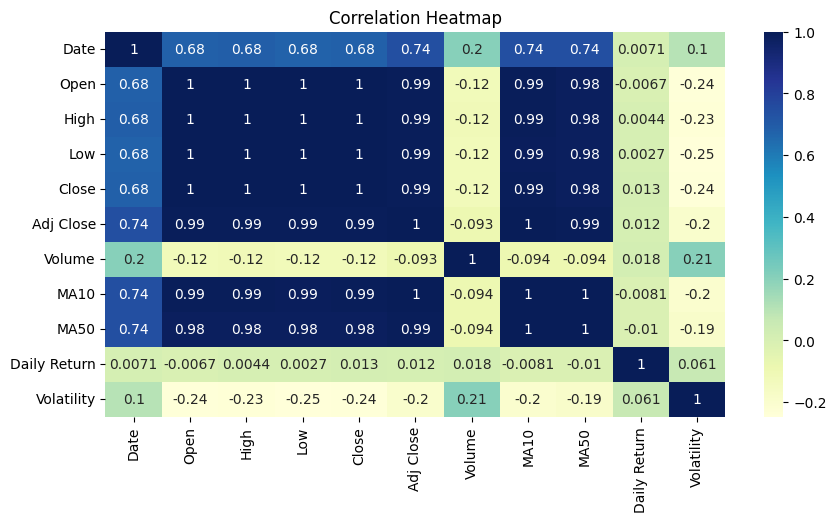

In [22]:
# Calculating the correlation matrix
correlation_matrix = rolls.corr()

# Creating a heatmap
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.title('Correlation Heatmap')
plt.show()

Lagged Features or Time-Shifted Features

This feature captures the prices for past stock prices and trends

Lagged features are commonly used in time series analysis and forecasting. It allows to capture temporal dependencies and patterns in the data. For instance, predicting tomorrow's stock price might benefit from knowing the stock price over the past few days.

In [23]:
# Generating Lagged Features
for lag in range(1, 8):  # Created lagged features for 1 to 7 days
    rolls[f'Lag_{lag}'] = rolls['Adj Close'].shift(lag)

**TIME SERIES ANALYSIS and FORECASTING**

Decompose Time Series

Time series decomposition is used to separate the data into trend, seasonality, and residual components. This to understanding the underlying patterns in the data.

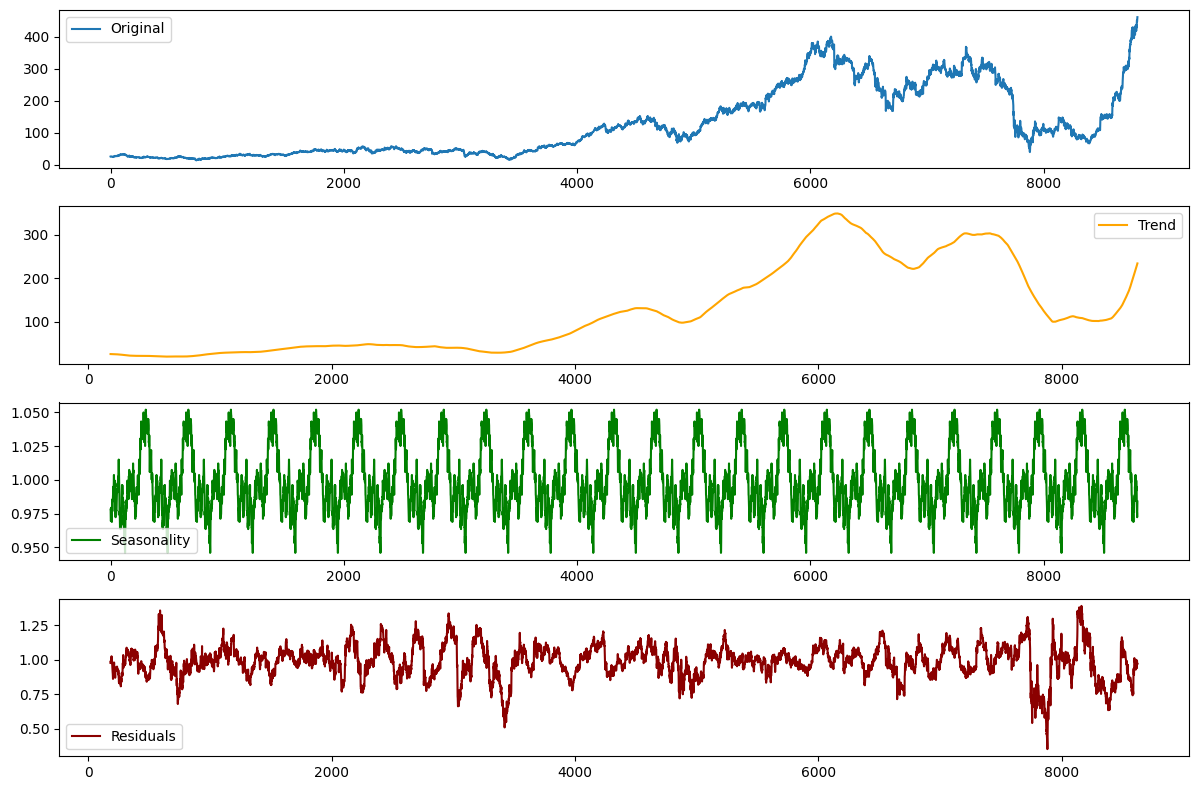

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Decompose the Time Series
decomposition = sm.tsa.seasonal_decompose(rolls['Adj Close'], model='multiplicative', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting Decomposed Components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(rolls['Adj Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='darkred')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Applying Time Series Forecasting Model:

ARIMA (Auto-Regressive Integrated Moving Average) Model for Forecasting, and Evaluating performances using MAE RMSE and R-square

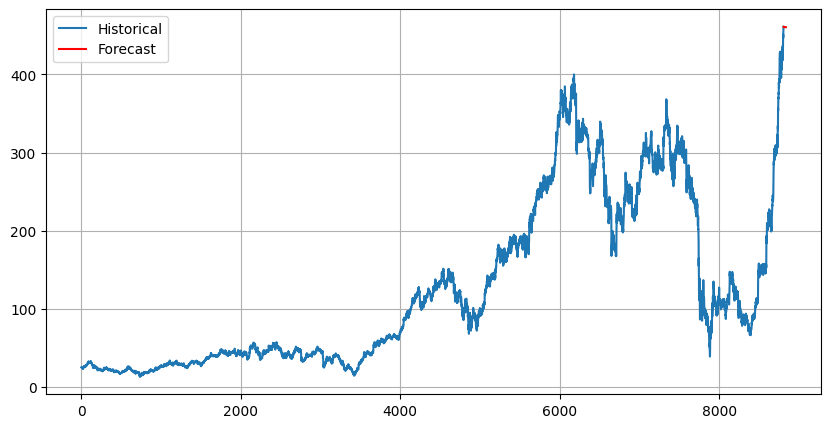

MAE: 34.499567188419256
RMSE: 38.014102063583806
R2 Score: -4.647676926152767


In [25]:
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fitting ARIMA model
model = ARIMA(rolls['Adj Close'], order=(5, 1, 0))
model_fit = model.fit()

# Making predictions
forecast = model_fit.forecast(steps=30)  # Forecasting for next 30 days

# Plotting the forecast
plt.figure(figsize=(10, 5))
plt.plot(rolls['Adj Close'], label='Historical')
plt.plot(forecast, label='Forecast', color='red')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Calculating MAE, RMSE and R2
y_true = rolls['Adj Close'][-30:]  # Last 30 actual values
y_pred = forecast
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2_scores = r2_score(y_true, y_pred)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2_scores}')


**APPLYING MACHINE LEARNING MODEL**